# Train Simple Car (4D) Gaussian Process Model

In [9]:
import torch
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import gpytorch

from torch.utils.data import DataLoader
from src.datasets import DiscreteDynamicsDataset
from src.gp_dynamics import VariationalGPDynamics
from src.models import SimpleCar

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup Model

In [21]:
# Parameters
name = 'data/simple_car_model_ngd.pt'    # This is trained
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Setup Model
nx = 4
nu = 2
ni = 256

BATCH_SIZE = ni
train_data = torch.load('data/train_simple_car_data.pt')
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
batch = next(iter(train_loader))

inducing_pts = torch.stack(4*[torch.cat((batch['x'], batch['u']), axis=-1)])

model = VariationalGPDynamics(nx, nu, num_inducing_pts=ni, inducing_pts=inducing_pts, mean='zero', model_path=name, device=device)

### Load

In [16]:
model.load(name)

=> loading model checkpoint 'data/simple_car_model_ngd_predictiveLogLikelihood.pt'
=> loaded checkpoint 'data/simple_car_model_ngd_predictiveLogLikelihood.pt'


In [25]:
len(train_loader)

62

### Train

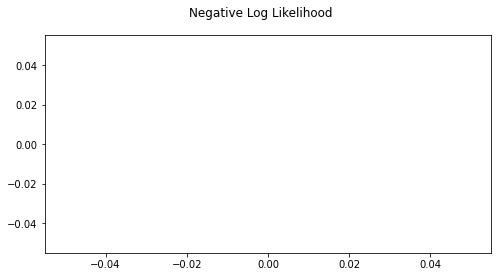

NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cuda: For batch 2: U(41,41) is zero, singular U.

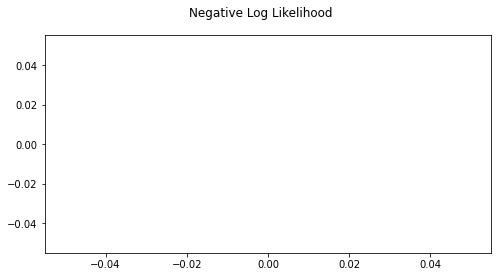

In [20]:
# Load Data
BATCH_SIZE = 1024*2
train_data = torch.load('data/train_simple_car_data.pt')
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

model.train(train_loader, num_epochs=20000, lr=(0.01,0.01), plot_loss=True)

### Test

Done. Total time: 1.2023980617523193 s | Time per step: 0.009393734857439995


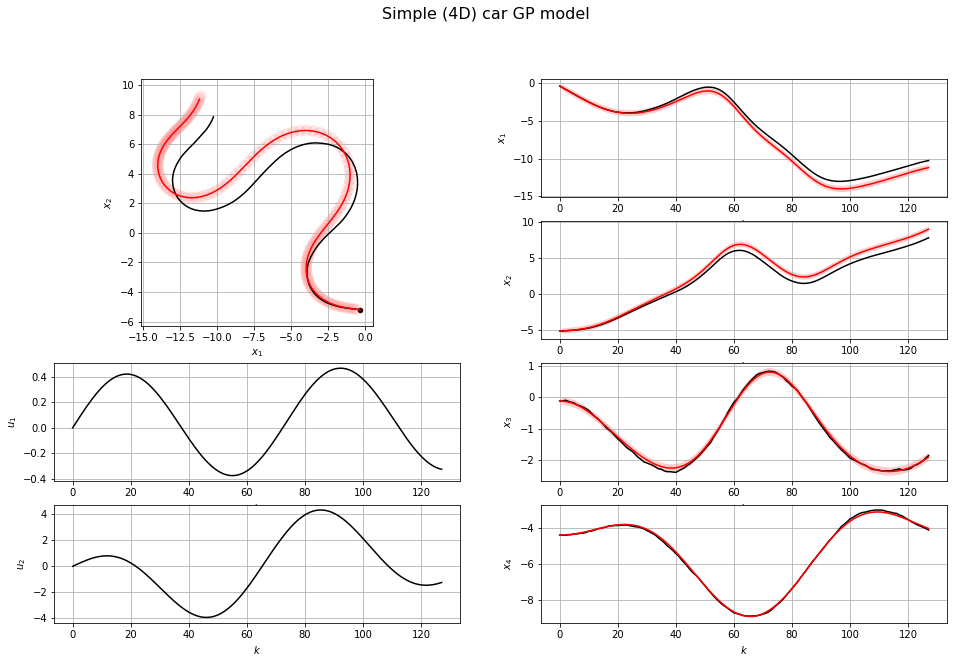

In [5]:
# Load Data
T = 128
test_data = torch.load('data/test_simple_car_data.pt')
test_loader = DataLoader(test_data, batch_size=T, drop_last=True)

model.eval()

# Which test trajectory to plot
trajectory_id = 1

if trajectory_id >= len(test_loader):
    raise ValueError(f"args.plot is greater than the number of available batches (num = {len(test_loader)})")

for i, data in enumerate(test_loader):
    x_exact = data['x']
    u = data['u']
    dx_exact = data['dx']

    if i == trajectory_id:
        break

x_test = torch.zeros((T + 1, nx))
cov_test = torch.zeros((T + 1, nx, nx))
std_test = torch.zeros((T + 1, nx))
x_test[0] = x_exact[0]

start_time = time.time()

with torch.no_grad():
    for k in range(T):
#         x_test[k+1], cov_test[k+1] = unscented_transform(x_test[k], cov_test[k], u[k], model.predict)
        x_test[k+1], cov_test[k+1], _, _ = model.predict(x_test[k], u[k])
        std_test[k+1] = torch.diag(cov_test[k+1]).sqrt()

ttime = time.time() - start_time
print(f'Done. Total time: {ttime} s | Time per step: {ttime/T}')


# ------------------------ Plot -------------------------------

fig = plt.figure(figsize=(16,10))
fig.suptitle('Simple (4D) car GP model', fontsize=16)
ax = fig.add_subplot(221)
ax.plot(x_exact[:,0], x_exact[:,1], c='k') # Particle trajectories
ax.plot(x_test[:-1,0], x_test[:-1,1], c='r') # Particle trajectories
ax.scatter(x_exact[0,0], x_exact[0,1], c='k', marker='o', s=20)
for k in range(T+1):
    ax.add_patch(Ellipse((x_test[k,0], x_test[k,1]), width=4*std_test[k,0], height=4*std_test[k,1], facecolor='r', alpha=0.1))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect('equal', 'box')
ax.grid(True)

ax = fig.add_subplot(425)
ax.plot(range(T), u[:,0], c='k')
ax.set_xlabel('$k$')
ax.set_ylabel('$u_1$')
ax.grid(True)

ax = fig.add_subplot(427)
ax.plot(range(T), u[:,1], c='k')
ax.set_xlabel('$k$')
ax.set_ylabel('$u_2$')
ax.grid(True)

ax = fig.add_subplot(422)
ax.plot(range(T), x_exact[:,0], c='k')
ax.plot(range(T), x_test[:-1,0], c='r')
ax.fill_between(range(T), x_test[:-1,0] + 2*std_test[:-1,0], x_test[:-1,0] - 2*std_test[:-1,0], facecolor='r', alpha=0.2)
ax.set_xlabel('$k$')
ax.set_ylabel('$x_1$')
ax.grid(True)

ax = fig.add_subplot(424)
ax.plot(range(T), x_exact[:,1], c='k')
ax.plot(range(T), x_test[:-1,1], c='r')
ax.fill_between(range(T), x_test[:-1,1] + 2*std_test[:-1,1], x_test[:-1,1] - 2*std_test[:-1,1], facecolor='r', alpha=0.2)
ax.set_xlabel('$k$')
ax.set_ylabel('$x_2$')
ax.grid(True)

ax = fig.add_subplot(426)
ax.plot(range(T), x_exact[:,2], c='k')
ax.plot(range(T), x_test[:-1,2], c='r')
ax.fill_between(range(T), x_test[:-1,2] + 2*std_test[:-1,2], x_test[:-1,2] - 2*std_test[:-1,2], facecolor='r', alpha=0.2)
ax.set_xlabel('$k$')
ax.set_ylabel('$x_3$')
ax.grid(True)

ax = fig.add_subplot(428)
ax.plot(range(T), x_exact[:,3], c='k')
ax.plot(range(T), x_test[:-1,3], c='r')
ax.fill_between(range(T), x_test[:-1,3] + 2*std_test[:-1,3], x_test[:-1,3] - 2*std_test[:-1,3], facecolor='r', alpha=0.2)
ax.set_xlabel('$k$')
ax.set_ylabel('$x_4$')
ax.grid(True)